In [1]:
import argparse
import cv2
import numpy as np 
import os
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class bow:
    images = []
    correctlyPredicted = []
    wronglyPredicted = []
    def populateFiles(self,train, path):
        count = 0
        for folder in os.listdir(path):
            folderPath=path+"/"+folder
            for file in  os.listdir(folderPath):
                self.images.append(folderPath +"/"+ file)
        if(train is True):
            np.random.shuffle(self.images)
        return self.images

    def findDescrip(self,sift, img):
        #kp, des = sift.detectAndCompute(img, None)
        
        rows1, cols1 = img.shape[:2]
        keypoint1 = []
        for lrow in range(6, rows1-6, 6):
            for lcol in range(6, cols1 - 6, 6):
                keypoint = cv2.KeyPoint(lcol, lrow, 6, _class_id=0)
                keypoint1.append(keypoint)
        
        keypoint1, desc = sift.compute(img, keypoint1)

        return desc

    def readImage(self,imgPath):
        image = cv2.imread(imgPath, 0)
       # print('-------------= ',imgPath)
        return cv2.resize(image,(150,150))

    def stackDescrip(self,descriptor_list):
        descriptors = np.array(descriptor_list[0])
        for descriptor in descriptor_list[1:]:
            descriptors = np.vstack((descriptors, descriptor)) 

        return descriptors

    def extractFeatures(self,kmeans, descriptor_list, image_count, no_clusters):
        im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
        for i in range(image_count):
            for j in range(len(descriptor_list[i])):
                feature = descriptor_list[i][j]
                feature = feature.reshape(1, 128)
                idx = kmeans.predict(feature)
                im_features[i][idx] += 1

        return im_features


    def pltHist(self,im_features, no_clusters):
        x_scalar = np.arange(no_clusters)
        y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

        plt.bar(x_scalar, y_scalar)
        plt.xlabel("Visual Word Index")
        plt.ylabel("Frequency")
        plt.title("Complete Vocabulary Generated")
        plt.xticks(x_scalar + 0.5, x_scalar)
        plt.show()

    def svcParamSelection(self,X, y, kernel, nfolds):
        Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
        gammas = [0.1, 0.11, 0.095, 0.105]
        param_grid = {'C': Cs, 'gamma' : gammas}
        grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
        grid_search.fit(X, y)
        grid_search.best_params_
        return grid_search.best_params_

    def findSVM(self,im_features, train_labels, kernel):
        features = im_features
        if(kernel == "precomputed"):
            features = np.dot(im_features, im_features.T)

        params = self.svcParamSelection(features, train_labels, kernel, 5)
        C_param, gamma_param = params.get("C"), params.get("gamma")
        print(C_param, gamma_param)
        class_weight = {
            0: (807 / (7 * 140)),
            1: (807 / (7 * 140)),
            2: (807 / (7 * 133)),
            3: (807 / (7 * 70)),
            4: (807 / (7 * 42)),
            5: (807 / (7 * 140)),
            6: (807 / (7 * 142)) 
        }

        svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
        svm.fit(features, train_labels)
        return svm

    def plotConfusionMatrix(self,y_true, y_pred, classes,
                              normalize=False,
                              title=None,
                              cmap=plt.cm.Blues):
        if not title:
            if normalize:
                title = 'Normalized confusion matrix'
            else:
                title = 'Confusion matrix, without normalization'

        cm = confusion_matrix(y_true, y_pred)
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        print(cm)

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return ax

    def plotConfusions(self,true, predictions):
        np.set_printoptions(precision=2)

        class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
        self.plotConfusionMatrix(true, predictions, classes=class_names,
                          title='Confusion matrix, without normalization')

        self.plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

        plt.show()

    def findAccuracy(self,true, predictions):
        print ('accuracy score: %0.3f' % accuracy_score(true, predictions))

    def trainModel(self,path, no_clusters, kernel):
        print('path--------- ',path)
        self.images = self.populateFiles(True, path)
        print("Train images path detected.")
        sift = cv2.xfeatures2d.SIFT_create()
        descriptor_list = []
        train_labels = np.array([])
        label_count = 8
        image_count = len(self.images)
 
        for img_path in self.images:
            if("aquarium" in img_path):
                class_index = 0
            elif("desert" in img_path):
                class_index = 1
            elif("highway" in img_path):
                class_index = 2
            elif("kitchen" in img_path):
                class_index = 3
            elif("laundromat" in img_path):
                class_index = 4
            elif("park" in img_path):
                class_index = 5       
            elif("waterfall" in img_path):
                class_index = 6
            else:
                class_index = 7

            train_labels = np.append(train_labels, class_index)
            img = self.readImage(img_path)
            des = self.findDescrip(sift, img)
          #  print(des)
            descriptor_list.append(des)

        descriptors = self.stackDescrip(descriptor_list)

    #    print("Descriptors vstacked.  ------------->",descriptors)
        

        #kmeans = self.clusterDescriptors(descriptors, no_clusters)
        kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
        print("Descriptors clustered.")

        im_features = self.extractFeatures(kmeans, descriptor_list, image_count, no_clusters)
        print("Images features extracted.")

        scale = StandardScaler().fit(im_features)        
        im_features = scale.transform(im_features)
        print("Train images normalized.")

        self.pltHist(im_features, no_clusters)
        print("Features histogram plotted.")

        svm = self.findSVM(im_features, train_labels, kernel)
        print("SVM fitted.")
        print("Training completed.")

        return kmeans, scale, svm, im_features

    def testModel(self,path, kmeans, scale, svm, im_features, no_clusters, kernel):
        
        test_images = self.populateFiles(False, path)
        

        count = 0
        true = []
        descriptor_list = []

        name_dict =	{
            "0": "aquarium",
            "1": "desert",
            "2": "highway",
            "3": "kitchen",
            "4": "laundromat",
            "5": "park",
            "6": "waterfall",
            "7": "windmill"
        }

        sift = cv2.xfeatures2d.SIFT_create()

        for img_path in test_images:
            img = self.readImage(img_path)
            des = self.findDescrip(sift, img)

            if(des is not None):
                count += 1

                descriptor_list.append(des)

                if("aquarium" in img_path):
                    true.append("aquarium")
                elif("desert" in img_path):
                    true.append("desert")
                elif("highway" in img_path):
                    true.append("highway")
                elif("kitchen" in img_path):
                    true.append("kitchen")
                elif("laundromat" in img_path):
                    true.append("laundromat")
                elif("park" in img_path):
                    true.append("park")
                elif("waterfall" in img_path):
                    true.append("waterfall")
                else:
                    true.append("windmill")

        descriptors = self.stackDescrip(descriptor_list)

        test_features = self.extractFeatures(kmeans, descriptor_list, count, no_clusters)

        test_features = scale.transform(test_features)

        kernel_test = test_features
        if(kernel == "precomputed"):
            kernel_test = np.dot(test_features, im_features.T)

        predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
        
    
        for i in svm.predict(kernel_test):
            #if(name_dict[str(int(i))] == ):
            
            if (self.images[int(i)].find(name_dict[str(int(i))]) != -1):
                self.correctlyPredicted.append(self.images[int(i)])
                
            else:
                self.wronglyPredicted.append(self.images[int(i)])
                


        self.plotConfusions(true, predictions)
        print("Confusion matrixes plotted.")
       

        self.findAccuracy(true, predictions)
        print("Accuracy calculated.")
        print("Execution done.")
    
    def dispImages(self):
        print('Correcly predicted Images')
        plt.subplot(1,2,1)
        plt.imshow(cv2.imread(self.correctlyPredicted[0]))
        plt.imshow(cv2.imread(self.correctlyPredicted[1]))
        
        plt.subplot(1,2,2)
        print('Wrongly predicted Images')
        plt.imshow(cv2.imread(self.wronglyPredicted[0]))
        plt.imshow(cv2.imread(self.wronglyPredicted[1]))
        

    def run(self,train_path, test_path, no_clusters, kernel):
        kmeans, scale, svm, im_features = self.trainModel(train_path, no_clusters, kernel)
        self.testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel)
        self.dispImages()


path---------  ../dataset/SUN_data/SUN_data/train
Train images path detected.


C:\Users\msgto\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:257: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


Descriptors clustered.
Images features extracted.
Train images normalized.


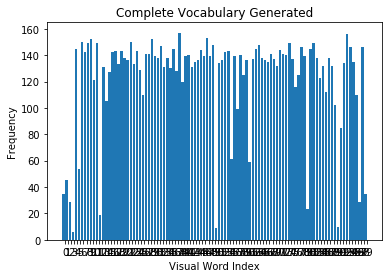

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
Confusion matrix, without normalization
[[88  1  3  1  4  2  0  1]
 [ 0 85  9  2  0  1  2  1]
 [ 1  9 86  0  1  0  0  3]
 [ 5  0  0 85  8  0  2  0]
 [ 2  1  0  4 91  1  1  0]
 [ 2  0  0  2  1 92  1  2]
 [ 9  1  1  1  3  2 83  0]
 [ 3  2  2  1  0  3  0 89]]
Normalized confusion matrix
[[ 0.88  0.01  0.03  0.01  0.04  0.02  0.    0.01]
 [ 0.    0.85  0.09  0.02  0.    0.01  0.02  0.01]
 [ 0.01  0.09  0.86  0.    0.01  0.    0.    0.03]
 [ 0.05  0.    0.    0.85  0.08  0.    0.02  0.  ]
 [ 0.02  0.01  0.    0.04  0.91  0.01  0.01  0.  ]
 [ 0.02  0.    0.    0.02  0.01  0.92  0.01  0.02]
 [ 0.09  0.01  0.01  0.01  0.03  0.02  0.83  0.  ]
 [ 0.03  0.02  0.02  0.01  0.    0.03  0.    0.89]]


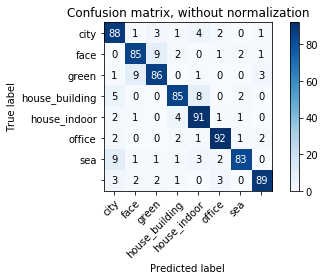

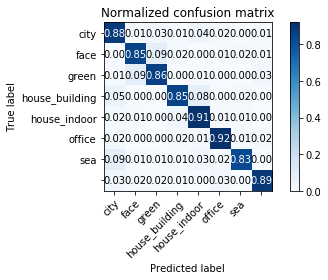

Confusion matrixes plotted.
accuracy score: 0.874
Accuracy calculated.
Execution done.
Correcly predicted Images
Wrongly predicted Images
800


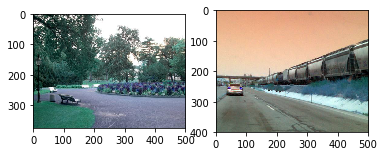

In [4]:
k=bow()
train_path='../dataset/SUN_data/SUN_data/train'
test_path='../dataset/SUN_data/SUN_data/test'
k.run(train_path, test_path, 100, 'precomputed')
print(len(k.images))

In [ ]:
k.run(train_path, test_path, 50, 'precomputed')

path---------  ../dataset/SUN_data/SUN_data/train
Train images path detected.
